In [887]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from final_algo import attr_threshold
from paper_sims_util import confusion
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#ls ROC_N_25_p_50_*result* | wc -l
#scp uma@uhlergroup.mit.edu:~/MTP2-algorithm/ROC_N_25* .

In [886]:
N = 500
p = 100
d = 0.01
if d is None:
    run_name = 'ROC_N_{}_p_{}'.format(N, p)
    d = 0.01
else:
    run_name = 'new_ROC/ROC_N_{}_p_{}_d_{}'.format(N, p, d)
NUM_GRAPHS = 30

In [898]:
if not os.path.isfile("{}_df.pkl".format(run_name)) or True:
    all_results = []
    data = []
    for graph_num in range(NUM_GRAPHS):
        start = time.time()
        print(graph_num)
        try:
            res = pickle.load(open('{}_{}_result.pkl'.format(run_name, graph_num), 'rb'))
        except:
            continue
        result, FPTP_dict, omega, _, recon_info = res
        all_results.append(FPTP_dict)
        
        for algo_name in FPTP_dict.keys():
            for lamb in FPTP_dict[algo_name].keys():
                omega_hat = result[algo_name][lamb]
                TP, TN, FP, FN = confusion(omega_hat, omega)
                #print(TP, TN, FP, FN)
                if TP + FN == 0:
                    TPR = 0
                else:
                    TPR = TP/(TP + FN)
                if FP+TN == 0:
                    FPR = 0
                else:
                    FPR = FP/(FP + TN)
                key_lamb = (tuple((lamb,)) if type(lamb) != tuple else lamb)
                data.append((graph_num, algo_name, key_lamb, FPR, TPR))
        print(time.time() - start)
#         for algo_name in FPTP_dict.keys():
#             SH_special = False
#             if algo_name == 'SH' and SH_special:
#                 start = time.time()
#                 SH_prec = recon_info['SH']
#                 for q in np.linspace(0.05, 1., num=40):
#                     omega_hat = attr_threshold(SH_prec, q)
#                     TP, TN, FP, FN = confusion(omega_hat, omega)
#                     TPR = TP/(TP + FN)
#                     FPR = FP/(FP + TN)
#                     data.append((graph_num, algo_name, tuple((q,)), FPR, TPR))
#                 end = time.time()
#                 #print(end-start)
#             else:
#                 for lamb, (FPR, TPR) in FPTP_dict[algo_name].items():
#                     if type(lamb) != tuple:
#                         lamb = tuple((lamb,))
#                     data.append((graph_num, algo_name, lamb, FPR, TPR))
    df = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'lambda', 'FPR', 'TPR'])
    df.to_pickle('{}_df.pkl'.format(run_name))
    print(len(all_results), 'unique runs')
else:
    print("Loaded df {}".format(run_name))
    df = pd.read_pickle("{}_df.pkl".format(run_name))
    print(df.RunID.nunique(), 'unique runs')

0
51.27855610847473
1
59.878294944763184
2
61.811691999435425
3


KeyboardInterrupt: 

In [893]:
df  = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'lambda', 'FPR', 'TPR'])

In [894]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()
    FPR_std = item.FPR.std()
    TPR_std = item.TPR.std()
    algo_name = key[0]
    run_id = item.RunID
    agg_data.append((run_id, algo_name, key[1], FPR_rate, TPR_rate, FPR_std, TPR_std))

In [895]:
no_agg_data = []
for key, item in df.groupby(['AlgoName', 'lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()
    

    algo_name = key[0]
    run_id = item.RunID
    for fpr, tpr in zip(item.FPR, item.TPR):
        no_agg_data.append((run_id, algo_name, key[1], fpr, tpr, None, None))

In [896]:
agg_df = pd.DataFrame(agg_data, columns=['RunID','Algorithm', 'Lambda', 'False Positive Rate', 'True Positive Rate', 'FPR_std', 'TPR_std'])



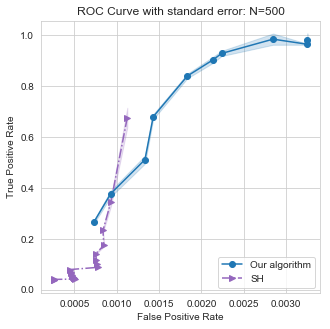

new_ROC/ROC_N_500_p_100_d_0.01


In [897]:
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))
#plt.xlim((0,1000))

all_algos = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_algos = ['our', 'SH']

smol = True
if smol:
    algos = relevant_algos
    ERRS = True
    small_name = 'errs'
else:
    algos = all_algos
    ERRS = False
    small_name = 'all'
    
for z, algo_name in enumerate(algos):
    plot_df = agg_df[agg_df.Algorithm == algo_name]
    plot_df.sort_values('False Positive Rate')
    x = plot_df['False Positive Rate']
    y = plot_df['True Positive Rate']
    std = plot_df['TPR_std']
    plt.plot(x, y,
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name],
             zorder = (10 if algo_name == 'our' else 1),
             alpha = (1. if algo_name != 'our' else 1.))
    if ERRS:
        plt.fill_between(x, y-std, y+std, alpha=0.2, color = colors[algo_name])
sns.set_style("whitegrid")
plt.legend(loc='lower right')
if smol:
    title = 'ROC Curve with standard error: N={}'.format(N)
else:
    title = 'ROC Curve with all algorithms: N={}'.format(N)
plt.title(title)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
fig.savefig('final_images/ROC_curve_{}_{}.png'.format(N, small_name))
print(run_name)